# Hybrid quanumt-classical Neural Networks with PyTorch and Qiskit
<p align="center">
<img src="../images/hybridnetwork.png" style="width:1000px;">
</p>

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

## 2. Create a Quantum Class with Qiskit
<p align="center">
<img src="../images/1qubitcirc.png" style="width:400px;">
</p>

$$
\sigma_z = \sum_i z_i p(z_i)
$$

In [2]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Expected value for rotation pi 0.54


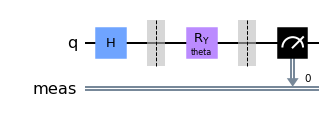

In [3]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw('mpl')

## 3. Create a Quantum-Classical Class with PyTorch

In [4]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(inputs[0].tolist())

        print("!!!!!", expectation_z, "!!!!!")

        result = torch.tensor([expectation_z])
        ctx.save_for_backward(inputs, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        inputs, expectation_z = ctx.saved_tensors
        input_list = np.array(inputs.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, inputs):
        return HybridFunction.apply(inputs, self.quantum_circuit, self.shift)

## 4. Data Loading and Preprocessing
### Training data

In [5]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_train.targets == 0)[0], 
#                 np.where(X_train.targets == 1)[0])

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)

In [6]:
# n_samples_show = 6

# data_iter = iter(train_loader)
# fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

# while n_samples_show > 0:
#     images, targets = data_iter.__next__()

#     axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
#     axes[n_samples_show - 1].set_xticks([])
#     axes[n_samples_show - 1].set_yticks([])
#     axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
#     n_samples_show -= 1

### Testing data

In [7]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0], 
#                 np.where(X_test.targets == 1)[0])

# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=256, shuffle=True)

## 5. Creating the Hybrid Neural Network

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)
        # self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid = [Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2) for i in range(10)]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        # x = x.view(1, -1)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.cat((hy(x) for hy in self.hybrid), -1) 
        # return torch.cat((x, 1-x), -1)
        # return F.softmax(x)

## 6. Training the Network

In [9]:
model = Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss().cuda()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.cuda()
        target = target.cuda()

        # Forward pass
        output = model(data)

        # Calculating loss
        loss = loss_func(output, target)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


TypeError: cat() received an invalid combination of arguments - got (generator, int), but expected one of:
 * (tuple of Tensors tensors, name dim, *, Tensor out)
 * (tuple of Tensors tensors, int dim, *, Tensor out)


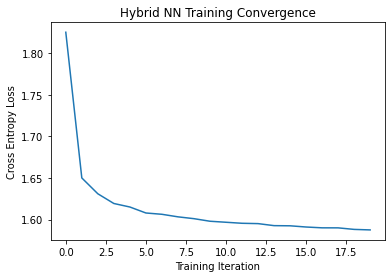

In [10]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iteration')
# plt.ylabel('Neg Log Likelihood Loss')
plt.ylabel('Cross Entropy Loss')
plt.show()

## 7. Testing the Network

In [13]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()

        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
    )   

Performance on test data:
	Loss: 1.5849
	Accuracy: 86.3%


In [12]:
# n_samples_show = 6
# count = 0
# fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

# model.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if count == n_samples_show:
#             break
#         data = data.cuda()
#         target = target.cuda()
        
#         output = model(data)

#         pred = output.argmax(dim=1, keepdim=True) 

#         axes[count].imshow(data[0].cpu().numpy().squeeze(), cmap='gray')

#         axes[count].set_xticks([])
#         axes[count].set_yticks([])
#         axes[count].set_title('Predicted {}'.format(pred.item()))
        
#         count += 1

ValueError: only one element tensors can be converted to Python scalars